In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import outils_data

In [38]:
df = pd.read_csv('Loan Data.csv')
df.sample(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
124,LP001439,Male,Yes,0,Not Graduate,No,4300,2014.0,194.0,360.0,1.0,Rural,Y
107,LP001370,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural,N
81,LP001266,Male,Yes,1,Graduate,Yes,2395,0.0,NaN,360.0,1.0,Semiurban,Y
410,LP002318,Female,No,1,Not Graduate,Yes,3867,0.0,62.0,360.0,1.0,Semiurban,N
489,LP002556,Male,No,0,Graduate,No,2435,0.0,75.0,360.0,1.0,Urban,N


---
**Identification des variables catégorielles et numériques**

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [40]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
numeric_columns.remove('Credit_History')
numeric_columns

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [41]:
categorical_columns = df.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
categorical_columns.append('Credit_History')
categorical_columns.remove('Loan_ID')
categorical_columns

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status',
 'Credit_History']

---
Description du dataframe, identification des valeurs nulles

In [42]:
df.shape

(614, 13)

In [43]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [44]:
df.describe(exclude=np.number)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [45]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

---
Analyses univariées

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64


C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


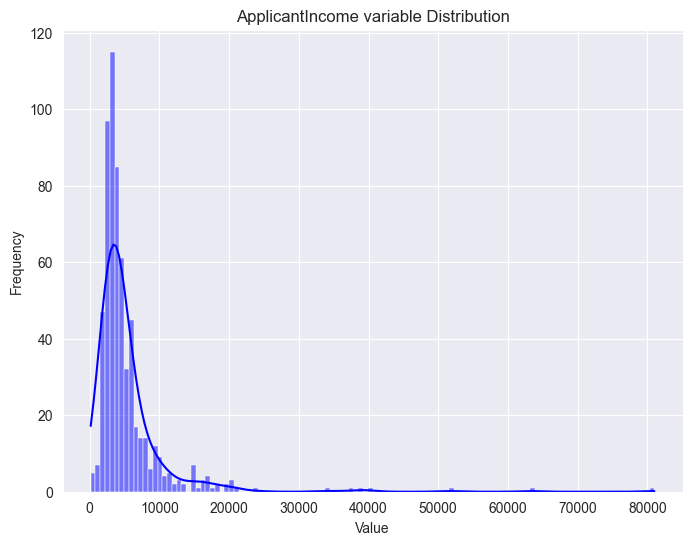

La variable ApplicantIncome ne suit pas une distribution normale.
count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64


C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


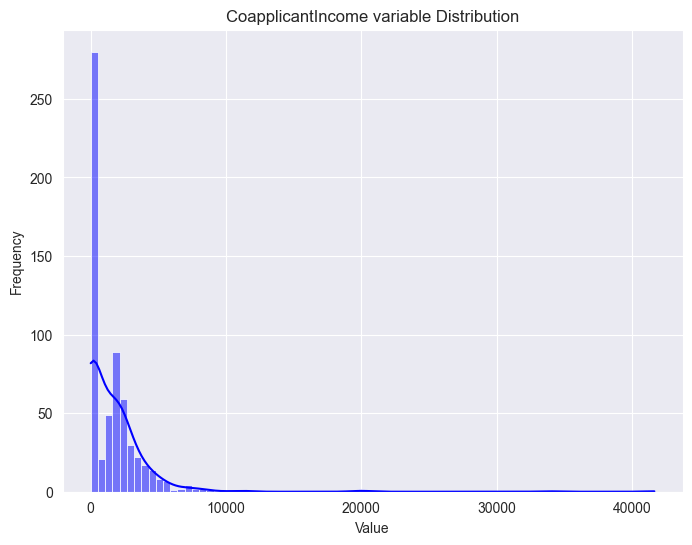

La variable CoapplicantIncome ne suit pas une distribution normale.
count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64


C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


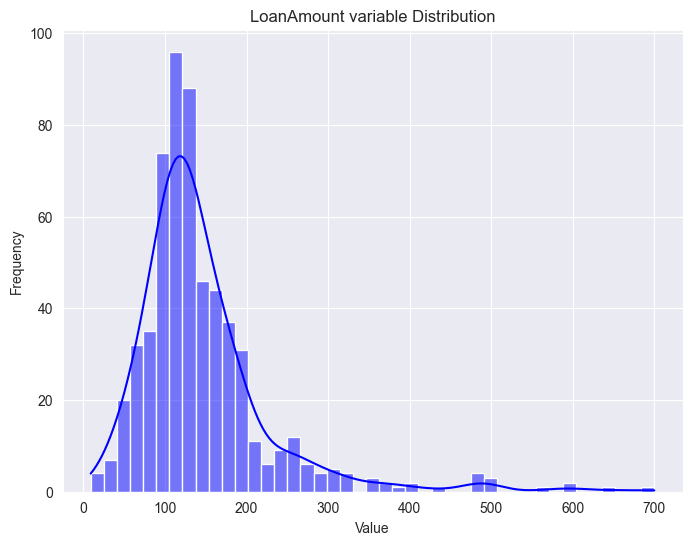

La variable LoanAmount suit une distribution normale.
count    600.00000
mean     342.00000
std       65.12041
min       12.00000
25%      360.00000
50%      360.00000
75%      360.00000
max      480.00000
Name: Loan_Amount_Term, dtype: float64


C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


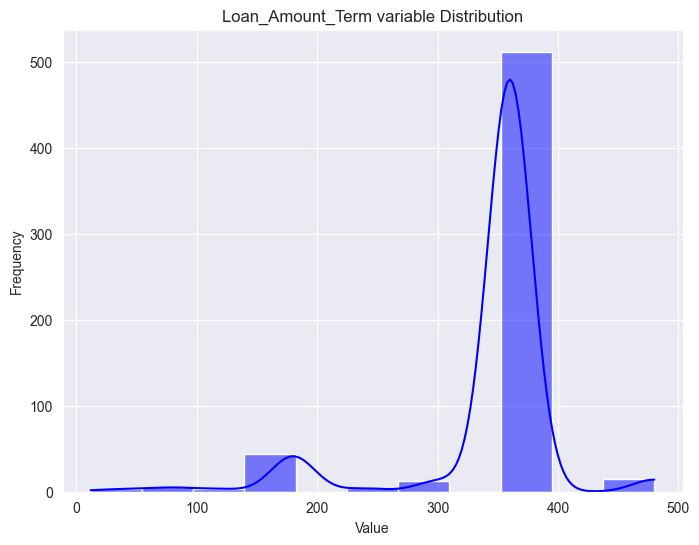

La variable Loan_Amount_Term suit une distribution normale.


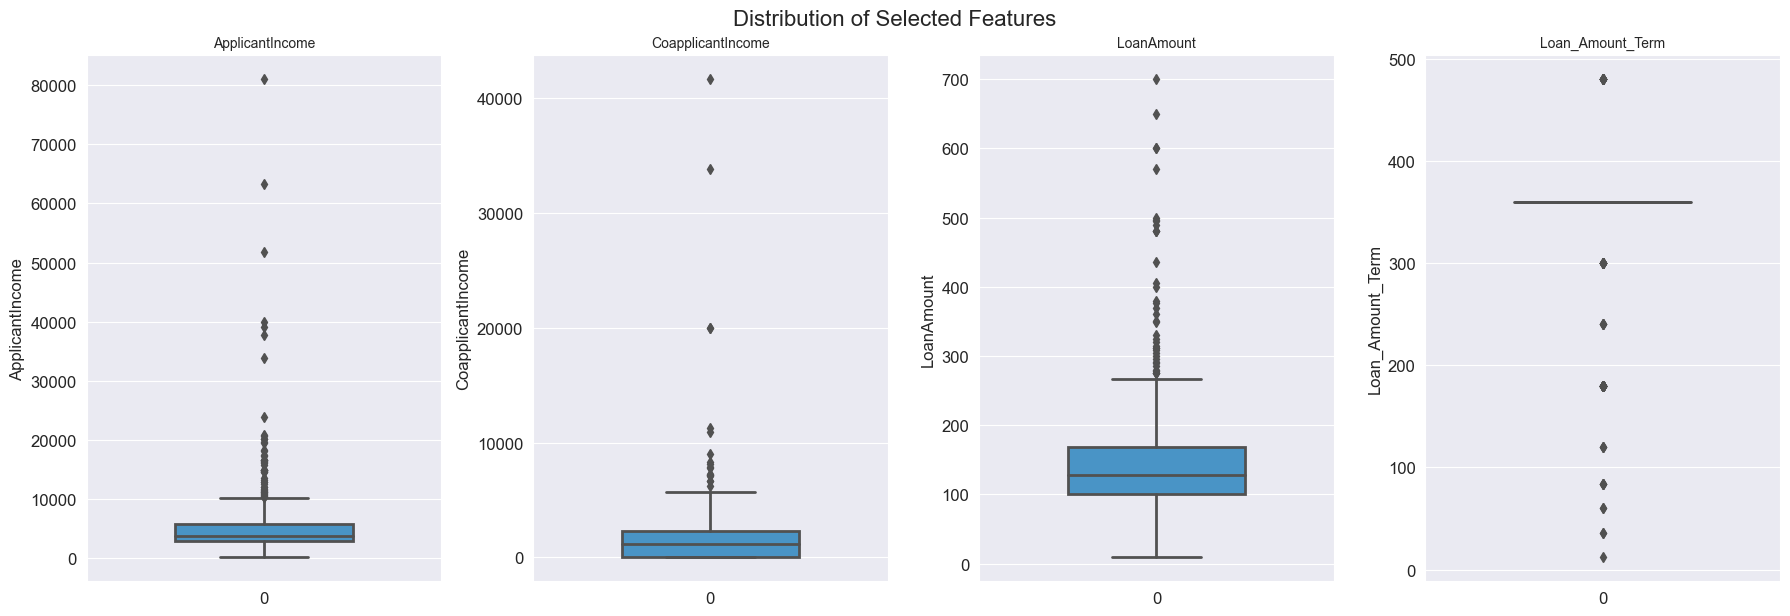

In [46]:
for column in numeric_columns:
    outils_data.distribution_curve(df, column)
    
    if (outils_data.normal_distribution(df, column, 0.05)) :
        print(f"La variable {column} suit une distribution normale.")
    else:
        print(f"La variable {column} ne suit pas une distribution normale.")

outils_data.draw_boxplots(numeric_columns, df)

In [47]:
for column in categorical_columns :
    print(f"{column} : {df[column].unique()}")

Gender : ['Male' 'Female' nan]
Married : ['No' 'Yes' nan]
Dependents : ['0' '1' '2' '3+' nan]
Education : ['Graduate' 'Not Graduate']
Self_Employed : ['No' 'Yes' nan]
Property_Area : ['Urban' 'Rural' 'Semiurban']
Loan_Status : ['Y' 'N']
Credit_History : [ 1.  0. nan]


In [48]:
df_inconnu = df.copy()
for column in categorical_columns :
    df_inconnu[column] = df_inconnu[column].fillna("Inconnu")
    
# Calculer les pourcentages d'occurrence
for column in categorical_columns :
    print("\n")
    pourcentages = df_inconnu[column].value_counts(normalize=True) * 100
    pourcentages = pourcentages.round(2)
    print(pourcentages)



Gender
Male       79.64
Female     18.24
Inconnu     2.12
Name: proportion, dtype: float64


Married
Yes        64.82
No         34.69
Inconnu     0.49
Name: proportion, dtype: float64


Dependents
0          56.19
1          16.61
2          16.45
3+          8.31
Inconnu     2.44
Name: proportion, dtype: float64


Education
Graduate        78.18
Not Graduate    21.82
Name: proportion, dtype: float64


Self_Employed
No         81.43
Yes        13.36
Inconnu     5.21
Name: proportion, dtype: float64


Property_Area
Semiurban    37.95
Urban        32.90
Rural        29.15
Name: proportion, dtype: float64


Loan_Status
Y    68.73
N    31.27
Name: proportion, dtype: float64


Credit_History
1.0        77.36
0.0        14.50
Inconnu     8.14
Name: proportion, dtype: float64


In [49]:
# Remplacement des valeurs NaN par le mode
df_na_filled = df.copy()
for column in categorical_columns :
    column_mode = df[column].mode()[0]
    df_na_filled[column] = df_na_filled[column].fillna(column_mode)

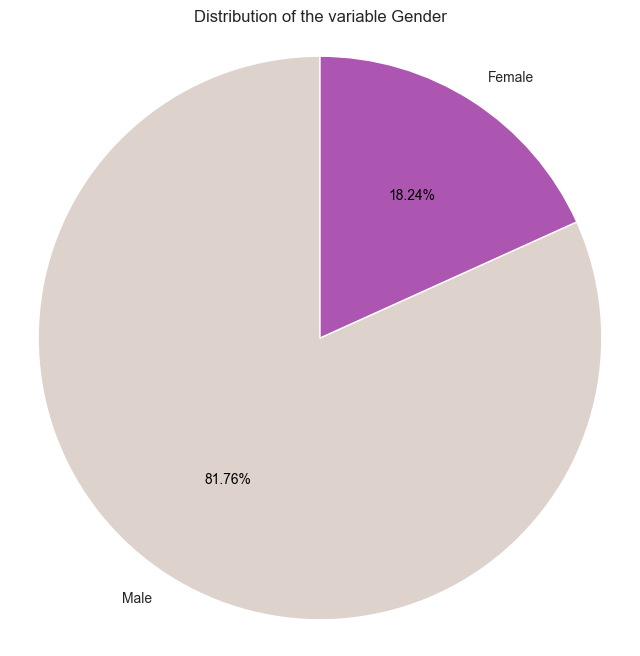

In [50]:
outils_data.draw_pieplot(df_na_filled,'Gender')

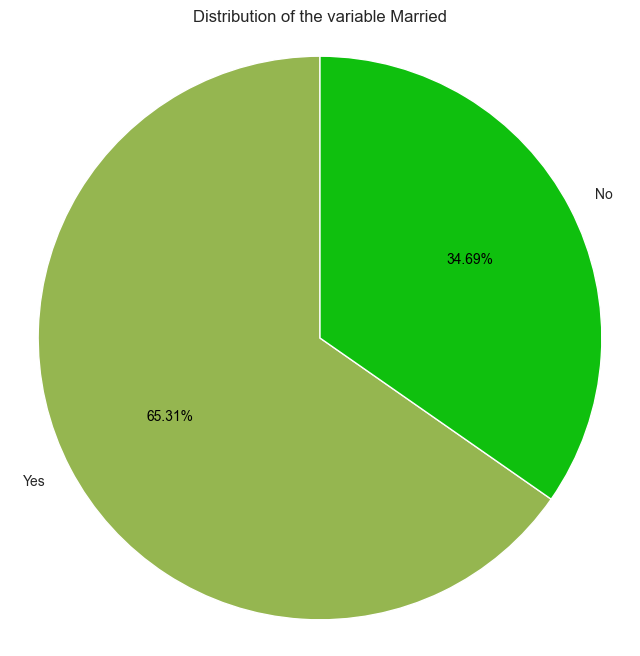

In [51]:
outils_data.draw_pieplot(df_na_filled,'Married')

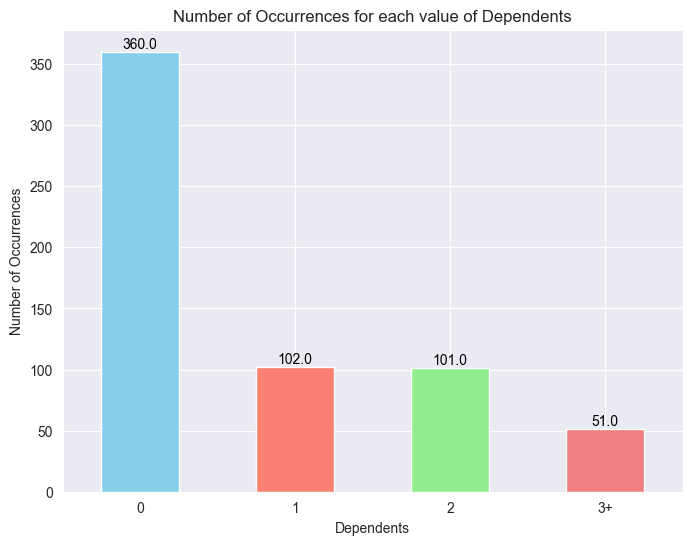

In [52]:
outils_data.draw_barplot(df_na_filled,'Dependents')

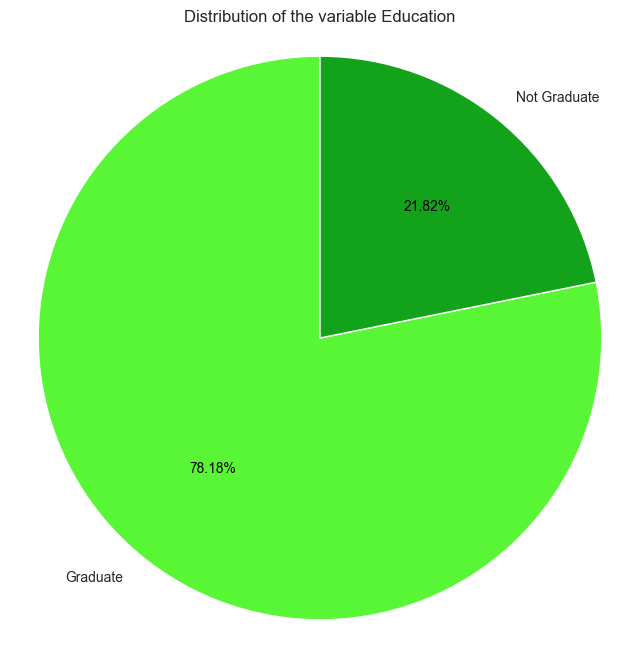

In [53]:
outils_data.draw_pieplot(df_na_filled,'Education')

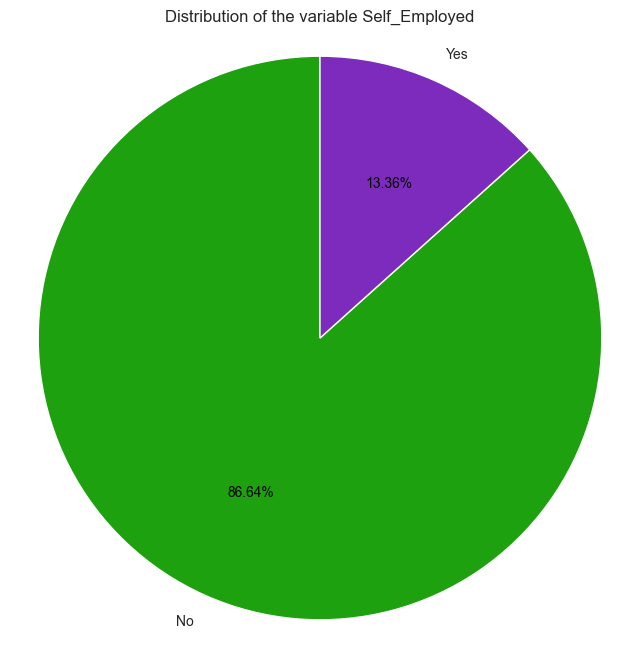

In [54]:
outils_data.draw_pieplot(df_na_filled,'Self_Employed')

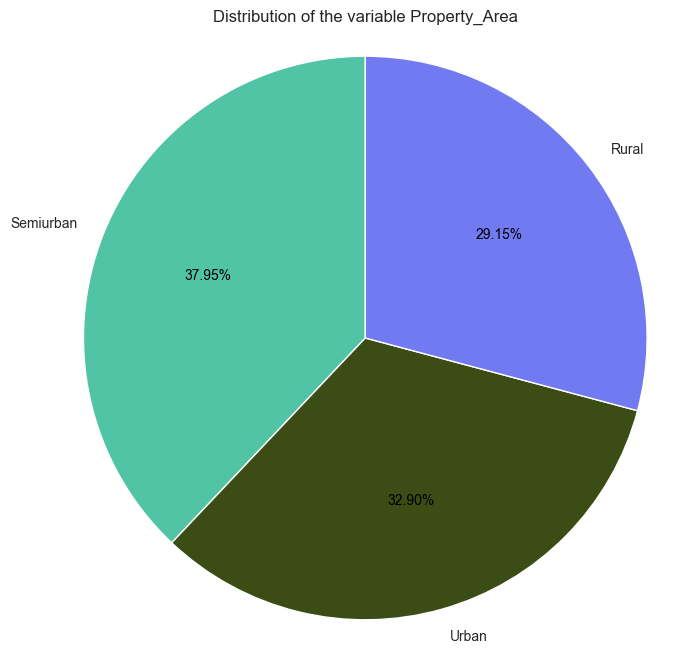

In [55]:
outils_data.draw_pieplot(df_na_filled,'Property_Area')

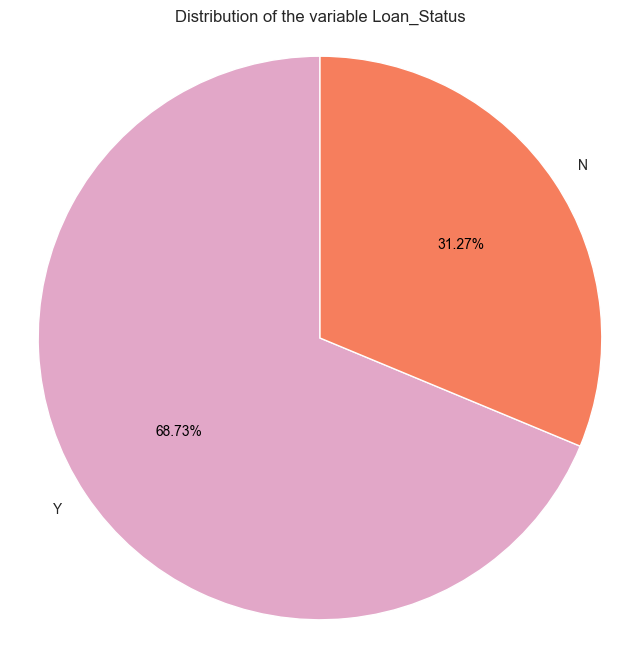

In [56]:
outils_data.draw_pieplot(df_na_filled,'Loan_Status')

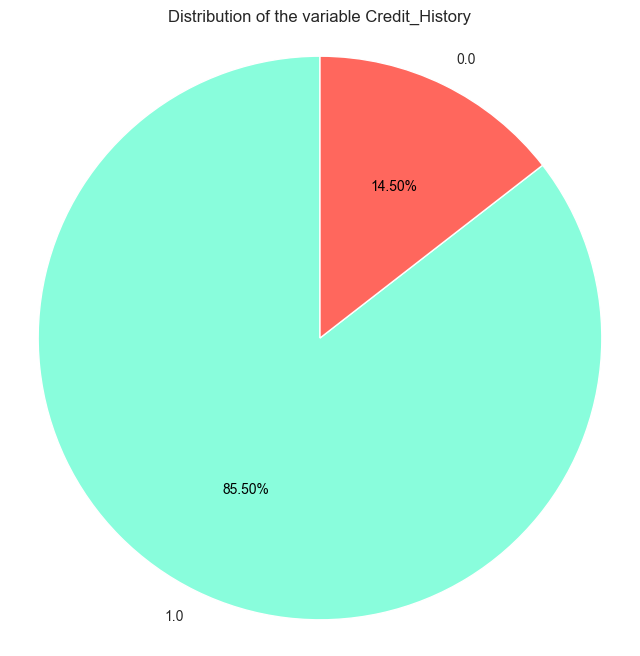

In [57]:
outils_data.draw_pieplot(df_na_filled,'Credit_History')

---
**Analyses bivariées**

In [58]:
df_corr = df[numeric_columns]
correl = df_corr.corr()
correl.style.background_gradient(cmap='coolwarm')

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878
LoanAmount,0.570909,0.188619,1.000000,0.039447
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000


<Axes: >

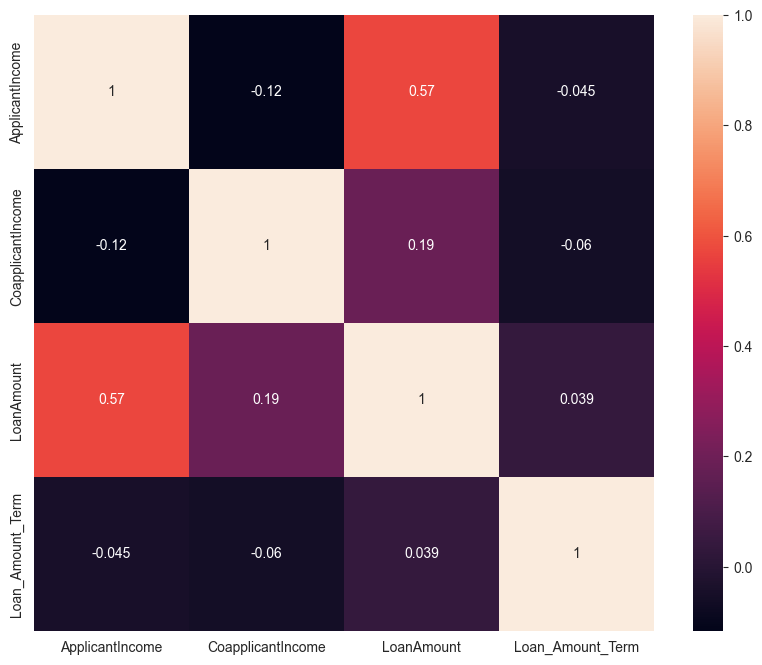

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), fmt='.2g', annot=True)

In [60]:
outils_data.chi_squared_tests(df_na_filled, categorical_columns)

Test du χ² entre Gender et Married:
Statistique de test du χ² : 79.63562874824729
Valeur de p : 4.502328957824834e-19
Degrés de liberté : 1
Fréquences attendues :
[[ 38.8534202  73.1465798]
 [174.1465798 327.8534202]]


Test du χ² entre Gender et Dependents:
Statistique de test du χ² : 19.49201865207906
Valeur de p : 0.00021627443011424633
Degrés de liberté : 3
Fréquences attendues :
[[ 65.66775244  18.60586319  18.42345277   9.3029316 ]
 [294.33224756  83.39413681  82.57654723  41.6970684 ]]


Test du χ² entre Gender et Education:
Statistique de test du χ² : 0.9951537284364683
Valeur de p : 0.31848601211356387
Degrés de liberté : 1
Fréquences attendues :
[[ 87.55700326  24.44299674]
 [392.44299674 109.55700326]]


Test du χ² entre Gender et Self_Employed:
Statistique de test du χ² : 0.0
Valeur de p : 1.0
Degrés de liberté : 1
Fréquences attendues :
[[ 97.04234528  14.95765472]
 [434.95765472  67.04234528]]


Test du χ² entre Gender et Property_Area:
Statistique de test du χ² : 7.79037

Remplaçons les valeurs nulles par la médiane pour les colonnes LoanAmount et Loan_Amount_Term

In [61]:
med_loan_amount = df_na_filled['LoanAmount'].median()
df_na_filled['LoanAmount'] = df_na_filled['LoanAmount'].fillna(med_loan_amount)

In [62]:
med_loan_amount_term = df_na_filled['Loan_Amount_Term'].median()
df_na_filled['Loan_Amount_Term'] = df_na_filled['Loan_Amount_Term'].fillna(med_loan_amount_term)

Pour chacune des colonnes numériques, on va essayer de voir le nombre d'outliers en utilisant les fonctions du module outils_data

In [63]:
df_to_use = df_na_filled.copy()

# Nous choisissons trois méthodes et nous imposons un seuil de 2 pour que ce soit un outlier
df_with_outliers = outils_data.dataframe_outliers(df_to_use, numeric_columns, outils_data.iqr, outils_data.zscore, cont=0.02)

for column in numeric_columns :
    df_outliers = outils_data.outliers_by_column(df_with_outliers, column, threshold=2)
    med = df_to_use[column].median()
    if df_to_use[column].dtype == 'int64' :
        med = int(med)
        
    for index, row in df_outliers.iterrows() :
        loan_id = row['Loan_ID']
        df_to_use.loc[df_to_use['Loan_ID']==loan_id, column] = med

**Mise en oeuvre des algorithmes**

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [65]:
df_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [66]:
# Encodage avec le One-Hot Encoding pour Property Area
df_to_use = pd.get_dummies(df_to_use, columns=["Dependents", "Gender", "Married", "Self_Employed", "Education", "Property_Area"])
df_to_use.sample(10)

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,...,Gender_Male,Married_No,Married_Yes,Self_Employed_No,Self_Employed_Yes,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
25,LP001066,9560,0.0,191.0,360.0,1.0,Y,True,False,False,...,True,False,True,False,True,True,False,False,True,False
296,LP001953,6875,0.0,200.0,360.0,1.0,Y,False,True,False,...,True,False,True,True,False,True,False,False,True,False
246,LP001814,9703,0.0,112.0,360.0,1.0,Y,False,False,True,...,True,False,True,True,False,True,False,False,False,True
442,LP002418,4707,1993.0,148.0,360.0,1.0,Y,False,False,False,...,True,True,False,True,False,False,True,False,True,False
101,LP001349,4843,3806.0,151.0,360.0,1.0,Y,True,False,False,...,True,True,False,True,False,True,False,False,True,False
593,LP002936,3859,3300.0,142.0,180.0,1.0,Y,True,False,False,...,True,False,True,True,False,True,False,True,False,False
139,LP001493,4200,1430.0,129.0,360.0,1.0,N,False,False,True,...,True,False,True,True,False,False,True,True,False,False
354,LP002143,2423,505.0,130.0,360.0,1.0,Y,True,False,False,...,False,False,True,True,False,True,False,False,True,False
371,LP002197,5185,0.0,155.0,360.0,1.0,Y,False,False,True,...,True,False,True,True,False,True,False,False,True,False
446,LP002434,4652,0.0,110.0,360.0,1.0,Y,False,False,True,...,True,False,True,True,False,False,True,True,False,False


In [67]:
# Changer manuellement les autres types de colonnes
df_to_use.loc[df_to_use['Loan_Status']=='N', 'Loan_Status'] = 0
df_to_use.loc[df_to_use['Loan_Status']=='Y', 'Loan_Status'] = 1
df_to_use['Loan_Status'] = df_to_use['Loan_Status'].astype(int)

df_to_use['Credit_History'] = df_to_use['Credit_History'].astype(int)

df_to_use.sample(10)

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,...,Gender_Male,Married_No,Married_Yes,Self_Employed_No,Self_Employed_Yes,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
377,LP002223,4310,0.0,130.0,360.0,1,1,True,False,False,...,True,False,True,True,False,True,False,False,True,False
523,LP002693,7948,7166.0,128.0,360.0,1,1,False,False,True,...,True,False,True,False,True,True,False,True,False,False
577,LP002874,3229,2739.0,110.0,360.0,1,1,True,False,False,...,True,True,False,True,False,True,False,False,False,True
93,LP001322,4133,0.0,122.0,360.0,1,1,True,False,False,...,True,True,False,True,False,True,False,False,True,False
259,LP001864,4931,0.0,128.0,360.0,1,0,False,False,False,...,True,False,True,True,False,False,True,False,True,False
143,LP001507,2698,2034.0,122.0,360.0,1,1,True,False,False,...,True,False,True,True,False,True,False,False,True,False
257,LP001854,5250,0.0,94.0,360.0,1,0,False,False,False,...,True,False,True,True,False,True,False,False,False,True
159,LP001552,4583,5625.0,255.0,360.0,1,1,True,False,False,...,True,False,True,True,False,True,False,False,True,False
248,LP001824,2882,1843.0,123.0,480.0,1,1,False,True,False,...,True,False,True,True,False,True,False,False,True,False
376,LP002219,8750,4996.0,130.0,360.0,1,1,False,False,False,...,True,False,True,True,False,True,False,True,False,False


In [68]:
# Division des données en features et target
X = df_to_use.drop(["Loan_ID", "Loan_Status"], axis=1).values
y = df_to_use["Loan_Status"].values

In [69]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Faire de l'oversampling pour rééquilibrer les classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=21)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

*Régression logistique*

In [71]:
# Entraînement du modèle
lr_model = LogisticRegression()
lr_model.fit(X_resampled, y_resampled)

C:\Users\PC\OneDrive\Documents\Formations Data\Travaux\ML\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [72]:
# Prédiction et évaluation
y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy : {accuracy}")
print(f"Classification report : \n{report}")

Accuracy : 0.7479674796747967
Classification report : 
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        43
           1       0.78      0.85      0.81        80

    accuracy                           0.75       123
   macro avg       0.72      0.70      0.71       123
weighted avg       0.74      0.75      0.74       123


---
*Random forest*

In [73]:
# Initialisation et entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [74]:
# Prédiction et évaluation
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy : {accuracy}")
print(f"Classification report : \n{report}")

Accuracy : 0.7560975609756098
Classification report : 
              precision    recall  f1-score   support

           0       0.76      0.44      0.56        43
           1       0.76      0.93      0.83        80

    accuracy                           0.76       123
   macro avg       0.76      0.68      0.70       123
weighted avg       0.76      0.76      0.74       123
